# Trajectory based playstyle identification
### Practical work by *Thomas Premm*

In [1]:
import lzma
import json
import random
import math
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from sklearn.preprocessing import StandardScaler

from awpy.visualization.plot import plot_map, plot_positions, position_transform
from awpy.data import MAP_DATA

### Function to read .xz archives from dataset

In [2]:
# Function to read .xz archives from ESTA
def read_parsed_demo(filename):
    with lzma.LZMAFile(filename, "rb") as f:
        d = json.load(f)
        return d

### Function to create a vector representation for a game state (also called a frame)

In [3]:
def create_frame_row(frame):
    frame_data = {}

  # Global info
    frame_data["secondsSincePhaseStart"] = frame["seconds"]
    frame_data["bombPlanted"] = frame["bombPlanted"]
    frame_data["bombsite"] = frame["bombsite"]
    frame_data["totalSmokes"] = len(frame["smokes"])
    frame_data["totalFires"] = len(frame["fires"])

    # Team specific info (CT)
    frame_data["ctAlive"] = 0
    frame_data["ctHp"] = 0
    frame_data["ctArmor"] = 0
    frame_data["ctHelmet"] = 0
    frame_data["ctEq"] = 0
    frame_data["ctUtility"] = 0
    frame_data["ctEqValStart"] = 0
    frame_data["ctBombZone"] = 0
    frame_data["defusers"] = 0
    for p in frame["ct"]["players"]:
        frame_data["ctEqValStart"] += p["equipmentValueFreezetimeEnd"]
        if p["isAlive"]:
            frame_data["ctAlive"] += 1
            frame_data["ctHp"] += p["hp"]
            frame_data["ctArmor"] += p["armor"]
            frame_data["ctHelmet"] += p["hasHelmet"]
            frame_data["ctEq"] += p["equipmentValue"]
            frame_data["ctUtility"] += p["totalUtility"]
            frame_data["defusers"] += p["hasDefuse"]
            if p["isInBombZone"]:
                frame_data["ctBombZone"] += 1
  
    # Team specific info (T)
    frame_data["tAlive"] = 0
    frame_data["tHp"] = 0
    frame_data["tArmor"] = 0
    frame_data["tHelmet"] = 0
    frame_data["tEq"] = 0
    frame_data["tUtility"] = 0
    frame_data["tEqValStart"] = 0
    frame_data["tHoldingBomb"] = 0
    frame_data["tBombZone"] = 0
    for p in frame["t"]["players"]:
        frame_data["tEqValStart"] += p["equipmentValueFreezetimeEnd"]
        if p["isAlive"]:
            frame_data["tAlive"] += 1
            frame_data["tHp"] += p["hp"]
            frame_data["tArmor"] += p["armor"]
            frame_data["tHelmet"] += p["hasHelmet"]
            frame_data["tEq"] += p["equipmentValue"]
            frame_data["tUtility"] += p["totalUtility"]
            if p["isInBombZone"]:
                frame_data["tBombZone"] += 1
            if p["hasBomb"]:
                frame_data["tHoldingBomb"] = 1

    return frame_data

### Function to create a set representation of a game state.
Each element in the set is a vector of [global info, player-specific info]

In [4]:

def create_frame_set(frame, map_name):
    # Global info
    seconds = frame["seconds"]

    # Player specific info CT
    player_list_ct = []
    velocity_list_ct = []
    for p in frame["ct"]["players"]:
        player_vec = [
                      seconds,
                      p["x"],
                      p["y"],
                      p["z"],
                      1, # 1 for CT, 0 for T

        ]
        velocity_vec = [
                      seconds,
                      p["velocityX"],
                      p["velocityY"],
                      p["velocityZ"],
                      1, # 1 for CT, 0 for T

        ]
        player_list_ct.append(np.array(player_vec))
        velocity_list_ct.append(np.array(velocity_vec))
    
    # Player specific info T
    player_list_t = []
    velocity_list_t = []
    for p in frame["t"]["players"]:
        player_vec = [
                      seconds,
                      p["x"],
                      p["y"],
                      p["z"],
                      0, # 1 for CT, 0 for T

        ]
        velocity_vec = [
                      seconds,

                      p["velocityX"],
                      p["velocityY"],
                      p["velocityZ"],
                      0, # 1 for CT, 0 for T

        ]
        player_list_t.append(np.array(player_vec))
        velocity_list_t.append(np.array(velocity_vec))
    
    # returning positions and velocity of CT, positions and velocity of T
    return np.array(player_list_ct), np.array(velocity_list_ct), np.array(player_list_t), np.array(velocity_list_t)

## Total Distance

In [5]:
def add_total_distances(df):
    total_distances = []
    for i in range(df.shape[0]):
        dist = 0
        for j in range(df.shape[1]-1):
            try:            
                point1 = df.iloc[i,j][1:4]
                point2 = df.iloc[i,j+1][1:4]
                # remember this is the distance in 3D and NOT 2D
                dist += math.dist(point1, point2)
            except:
                pass
        total_distances.append(dist)
    return total_distances

## Start to End Distance

In [6]:
def add_start_to_end_distances(df):
    ste_distances = []
    for i in range(df.shape[0]):
        for j in range(1, df.shape[1]+1):
            try:
                ste_distance = math.dist(df.iloc[i,0][1:4], df.iloc[i,-j][1:4])
                ste_distances.append(ste_distance)
                break
            except:
                pass
    return ste_distances

### Number of Turning Points

In [7]:
def angle_test(df, min_angle):
    epsilon = 1e-7
    turning_points = []
    for i in range(df.shape[0]):
        #angle = 0
        count = 0
        for j in range(df.shape[1]-2):
            try:
                ba = df.iloc[i, j-1][1:3] - df.iloc[i, j][1:3]
                bc = df.iloc[i, j+1][1:3] - df.iloc[i, j][1:3]
                cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + epsilon)
                angle = np.arccos(cosine_angle)  # This is in radians
                angle_degrees = np.degrees(angle)  # Convert to degrees
                #print(np.degrees(ang))
                if angle_degrees > min_angle:
                    count += 1
            except:
                pass
        turning_points.append(count)
    return turning_points

### Average Speed

In [8]:
def avg_speed(df):
    avg_speed = []
    for i in range(df.shape[0]):
        x,y = 0,0
        error = df.shape[1]
        for j in range(df.shape[1]):
            try:
                x += abs(df.iloc[i,j][1])
                y += abs(df.iloc[i,j][2])
            except:
                error-=1
        tmp = [x/error,y/error]
        avg_speed.append(tmp)
    return avg_speed

### Last but not least the convex hull with centroids and gyration radius

In [9]:
def convex_hull_calc(df):
    convex_hull_areas = np.zeros(df.shape[0])
    hull_centroids = np.zeros((df.shape[0], 2))

    for i in range(df.shape[0]):
        trajectory = []
        for j in range(df.shape[1]):
            try:
                point = df.iloc[i,j][1:3].tolist()
                trajectory.append(point)
            except:
                pass
        hull = ConvexHull(trajectory)
        convex_hull_areas[i] = hull.volume  # In 2D, hull.volume is the area
        hull_centroids[i] = np.mean(hull.points[hull.vertices], axis=0)
        
    return convex_hull_areas, hull_centroids


In [10]:
def gyration_calc(df, centroids):
    gyration = np.zeros(df.shape[0])

    for i in range(df.shape[0]):
        points = []
        for j in range(df.shape[1]):
            try:
                points.append(df.iloc[i,j][1:3].tolist())
            except:
                pass

        # Convert list of points to a NumPy array
        points_array = np.array(points)

        # Ensure there are points and a centroid to calculate gyration
        if len(points_array) > 0 and centroids[i] is not None:
            # Compute the squared distance from each point to the centroid
            squared_distances = np.sum((points_array - centroids[i])**2, axis=1)
            
            # Calculate the mean of squared distances
            mean_squared_distance = np.mean(squared_distances)
            
            # The radius of gyration is the square root of the mean squared distance
            gyration[i] = np.sqrt(mean_squared_distance)
        else:
            gyration[i] = np.nan  # Use NaN to indicate missing or undefined values

    return gyration


To keep it simple i will only use games that are played on the map *nuke* and then also compare the 2 opposing teams

### 1. Loading all the data
Here we have to adjust the path of the data to the location where we have downloaded the files

In [11]:
##### EDIT to location where the test/online files have been downloaded to #####
online_files = os.listdir("D:\Practical_Work\data\\test")
online_files = ["D:\Practical_Work\data\\test\\" + f for f in online_files]
################################################################################

demo_files = online_files

parsed_data = []

parsed_demos = {}

map_list = ['de_nuke', 'de_inferno', 'de_vertigo', 'de_dust2', 'de_mirage', 'de_overpass', 'de_ancient']

for m in map_list:
    parsed_demos[m] = {}

random.seed(0)

for f in tqdm(demo_files):
    demo = read_parsed_demo(f)

    if demo["mapName"] in map_list:
        parsed_demos[demo["mapName"]][demo["demoId"]] = {}
        #parsed_demos[demo["mapName"]][demo["demoId"]]["df"] = []
        #parsed_demos[demo["mapName"]][demo["demoId"]]["Y"] = []
        parsed_demos[demo["mapName"]][demo["demoId"]]["CT"] = []
        parsed_demos[demo["mapName"]][demo["demoId"]]["T"] = []
        parsed_demos[demo["mapName"]][demo["demoId"]]["VEL_CT"] = []
        parsed_demos[demo["mapName"]][demo["demoId"]]["VEL_T"] = []

        parsed_frames_df = []
        parsed_frames_set_X = []
        parsed_frames_set_Y = []

        for r in demo["gameRounds"]:
            #parsed_frames_df_round = []
            #parsed_frames_set_X_round = []
            #parsed_frames_set_Y_round = []

            ct_win = 1
            if r["roundEndReason"] in ["CTWin", "TargetSaved", "BombDefused", "TargetBombed", "TerroristsWin"]:
                if r["roundEndReason"] not in ["CTWin", "TargetSaved", "BombDefused"]:
                    ct_win = 0
                frame_set1 = []
                frame_set2 = []
                frame_set3 = []
                frame_set4 = []
                frame_set5 = []
                frame_set6 = []
                frame_set7 = []
                frame_set8 = []
                frame_set9 = []
                frame_set10 = []
                vel_set1 = []
                vel_set2 = []
                vel_set3 = []
                vel_set4 = []
                vel_set5 = []
                vel_set6 = []
                vel_set7 = []
                vel_set8 = []
                vel_set9 = []
                vel_set10 = []
                for fr in r["frames"]:
                    if (fr["ct"]["players"] is not None) & (fr["t"]["players"] is not None) & (fr["clockTime"] != "00:00") & (fr["t"]["alivePlayers"] >= 0) & (fr["ct"]["alivePlayers"] >= 1):
                        if (len(fr["ct"]["players"]) == 5) & (len(fr["t"]["players"]) == 5):
                            # Create dataframe
                            frame_row = create_frame_row(fr)
                            frame_row["ctWin"] = ct_win
                            frame_row["demoId"] = demo["demoId"]

                            frame_row["roundNum"] = r["roundNum"]
                            #parsed_frames_df_round.append(frame_row)

                            # Create sets
                            #parsed_frames_set_Y_round.append(ct_win)

                            frame_set_ct, velocity_ct, frame_set_t, velocity_t = create_frame_set(fr, demo["mapName"])
                            # this frame_set should be of all 10 players, so we can iterate over it
                            
                            #ct telemetry
                            frame_set1.append(frame_set_ct[0])
                            frame_set2.append(frame_set_ct[1])
                            frame_set3.append(frame_set_ct[2])
                            frame_set4.append(frame_set_ct[3])
                            frame_set5.append(frame_set_ct[4])
                            #ct velocity
                            vel_set1.append(velocity_ct[0])
                            vel_set2.append(velocity_ct[1])
                            vel_set3.append(velocity_ct[2])
                            vel_set4.append(velocity_ct[3])
                            vel_set5.append(velocity_ct[4])
                            
                            #t telemetry
                            frame_set6.append(frame_set_t[0])
                            frame_set7.append(frame_set_t[1])
                            frame_set8.append(frame_set_t[2])
                            frame_set9.append(frame_set_t[3])
                            frame_set10.append(frame_set_t[4])
                            #t velocity
                            vel_set6.append(velocity_t[0]) 
                            vel_set7.append(velocity_t[1])
                            vel_set8.append(velocity_t[2])
                            vel_set9.append(velocity_t[3])
                            vel_set10.append(velocity_t[4])
                            #parsed_frames_set_X_round.append(frame_set)

                if len(frame_set1) > 0:
                    #parsed_demos[demo["mapName"]][demo["demoId"]]["df"].append(parsed_frames_df_round)
                    #parsed_demos[demo["mapName"]][demo["demoId"]]["Y"].append(parsed_frames_set_Y_round)
                    parsed_demos[demo["mapName"]][demo["demoId"]]["CT"].append(frame_set1)
                    parsed_demos[demo["mapName"]][demo["demoId"]]["CT"].append(frame_set2)
                    parsed_demos[demo["mapName"]][demo["demoId"]]["CT"].append(frame_set3)
                    parsed_demos[demo["mapName"]][demo["demoId"]]["CT"].append(frame_set4)
                    parsed_demos[demo["mapName"]][demo["demoId"]]["CT"].append(frame_set5)
                                             
                    parsed_demos[demo["mapName"]][demo["demoId"]]["T"].append(frame_set6)
                    parsed_demos[demo["mapName"]][demo["demoId"]]["T"].append(frame_set7)
                    parsed_demos[demo["mapName"]][demo["demoId"]]["T"].append(frame_set8)
                    parsed_demos[demo["mapName"]][demo["demoId"]]["T"].append(frame_set9)
                    parsed_demos[demo["mapName"]][demo["demoId"]]["T"].append(frame_set10)
                                             
                                             
                    parsed_demos[demo["mapName"]][demo["demoId"]]["VEL_CT"].append(vel_set1)
                    parsed_demos[demo["mapName"]][demo["demoId"]]["VEL_CT"].append(vel_set2)
                    parsed_demos[demo["mapName"]][demo["demoId"]]["VEL_CT"].append(vel_set3)
                    parsed_demos[demo["mapName"]][demo["demoId"]]["VEL_CT"].append(vel_set4)
                    parsed_demos[demo["mapName"]][demo["demoId"]]["VEL_CT"].append(vel_set5)
                                             
                    parsed_demos[demo["mapName"]][demo["demoId"]]["VEL_T"].append(vel_set6)
                    parsed_demos[demo["mapName"]][demo["demoId"]]["VEL_T"].append(vel_set7)
                    parsed_demos[demo["mapName"]][demo["demoId"]]["VEL_T"].append(vel_set8)
                    parsed_demos[demo["mapName"]][demo["demoId"]]["VEL_T"].append(vel_set9)
                    parsed_demos[demo["mapName"]][demo["demoId"]]["VEL_T"].append(vel_set10)

  0%|          | 0/680 [00:00<?, ?it/s]

100%|██████████| 680/680 [39:29<00:00,  3.48s/it]


### 2. Creating the dataframes

In [12]:
# initializing the DataFrames
# 'de_nuke', 'de_inferno', 'de_vertigo', 'de_dust2', 'de_mirage', 'de_overpass', 'de_ancient'

df_nuke_ct = pd.DataFrame()
df_nuke_t = pd.DataFrame()
df_nuke_vel_ct = pd.DataFrame()
df_nuke_vel_t = pd.DataFrame()

for maps in parsed_demos.keys():
    for game in parsed_demos[maps].keys():
        if maps == 'de_nuke':
            df_nuke_ct = pd.concat([df_nuke_ct, pd.DataFrame(parsed_demos[maps][game]['CT'])], ignore_index=True)
            df_nuke_t = pd.concat([df_nuke_t, pd.DataFrame(parsed_demos[maps][game]['T'])], ignore_index=True)
            df_nuke_vel_ct = pd.concat([df_nuke_vel_ct, pd.DataFrame(parsed_demos[maps][game]['VEL_CT'])], ignore_index=True)
            df_nuke_vel_t = pd.concat([df_nuke_vel_t, pd.DataFrame(parsed_demos[maps][game]['VEL_T'])], ignore_index=True)

### 3. Computing all the metrics

total_distances done!
start_to_end_distances done!
straightness index done!
urning points done!
average speed done!
convex hull done!
gyration radius done!


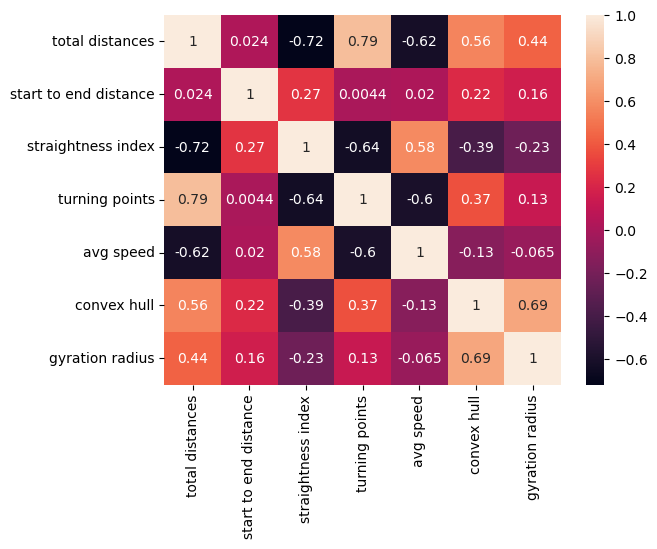

In [13]:
# total distances
nuke_total_distances_ct = add_total_distances(df_nuke_ct)
nuke_total_distances_t = add_total_distances(df_nuke_t)
print("total_distances done!")

# start to end distances
nuke_start_to_end_distances_ct = add_start_to_end_distances(df_nuke_ct)
nuke_start_to_end_distances_t = add_start_to_end_distances(df_nuke_t)
print("start_to_end_distances done!")

# straightness index
nuke_ratio_ct = [nuke_start_to_end_distances_ct[i] / nuke_total_distances_ct[i] for i in range(len(nuke_start_to_end_distances_ct))]
nuke_ratio_t = [nuke_start_to_end_distances_t[i] / nuke_total_distances_t[i] for i in range(len(nuke_start_to_end_distances_t))]
print("straightness index done!")

# number of turning points
# choosing 90 as the number of min angle
min_angle = np.degrees(np.pi/2)
turning_points_ct = angle_test(df_nuke_ct, min_angle)
turning_points_t = angle_test(df_nuke_t, min_angle)
print("turning points done!")

# average speed
avg_speed_ct_nuke = avg_speed(df_nuke_vel_ct)
avg_speed_t_nuke = avg_speed(df_nuke_vel_t)
avg_speed_ct_nukel = []
avg_speed_t_nukel = []
for i in range(len(avg_speed_ct_nuke)):
    avg_speed_ct_nukel.append(np.sqrt(avg_speed_ct_nuke[i][0]**2 + avg_speed_ct_nuke[i][1]**2))
    avg_speed_t_nukel.append(np.sqrt(avg_speed_t_nuke[i][0]**2 + avg_speed_t_nuke[i][1]**2))
print("average speed done!")

# convex hull
convex_hull_ct_nuke, centroids_ct_nuke = convex_hull_calc(df_nuke_ct)
convex_hull_t_nuke, centroids_t_nuke = convex_hull_calc(df_nuke_t)
print("convex hull done!")

# gyration radius
gyration_radius_ct_nuke = gyration_calc(df_nuke_ct, centroids_ct_nuke)
gyration_radius_t_nuke = gyration_calc(df_nuke_t, centroids_t_nuke)
print("gyration radius done!")


# combining everything into 1 dictionary
dictionary = {"total distances":nuke_total_distances_ct, 
              "start to end distance":nuke_start_to_end_distances_ct, 
              "straightness index": nuke_ratio_ct,
              "turning points": turning_points_ct,
              "avg speed": avg_speed_ct_nukel,
              "convex hull": convex_hull_ct_nuke,
              "gyration radius": gyration_radius_ct_nuke
             }


# plotting the heatmap to see the correlation
metrics = pd.DataFrame(dictionary)
corr_matrix = metrics.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

Sorting out metrics that are highly correlated to each other to remove redundant information
<br>Therefore total_distances will get removed

In [14]:
dictionary_ct = {"start to end distance":nuke_start_to_end_distances_ct, 
              "straightness index": nuke_ratio_ct,
              "turning points": turning_points_ct,
              "avg speed": avg_speed_ct_nukel,
              "convex hull": convex_hull_ct_nuke,
              "gyration raius": gyration_radius_ct_nuke
             }

dictionary_t = {"start to end distance":nuke_start_to_end_distances_t, 
              "straightness index": nuke_ratio_t,
              "turning points": turning_points_t,
              "avg speed": avg_speed_t_nukel,
              "convex hull": convex_hull_t_nuke,
              "gyration raius": gyration_radius_t_nuke
             }

metrics_ct_nuke_df = pd.DataFrame(dictionary_ct)
metrics_t_nuke_df = pd.DataFrame(dictionary_t)

metrics_ct_nuke = metrics_ct_nuke_df.values
metrics_t_nuke = metrics_t_nuke_df.values

metrics_ct_nuke.shape

(14670, 6)

### 4. PCA and KMeans

First we have to standardize the data in order to perform PCA

In [20]:
# Initialize the StandardScaler
scaler_ct = StandardScaler()

# Fit the scaler to your data and then transform it
metrics_standardized_ct = scaler_ct.fit_transform(metrics_ct_nuke)

# Initialize the StandardScaler
scaler_t = StandardScaler()

# Fit the scaler to your data and then transform it
metrics_standardized_t = scaler_t.fit_transform(metrics_t_nuke)

Now lets perform PCA and then KMeans with $k \in \set{1,..., 10}$ and look what fits our data best. <br>
We can achieve this be doing the ellbow test, which determines the best k.<br>
Here we do this with the Counter Terrorists:

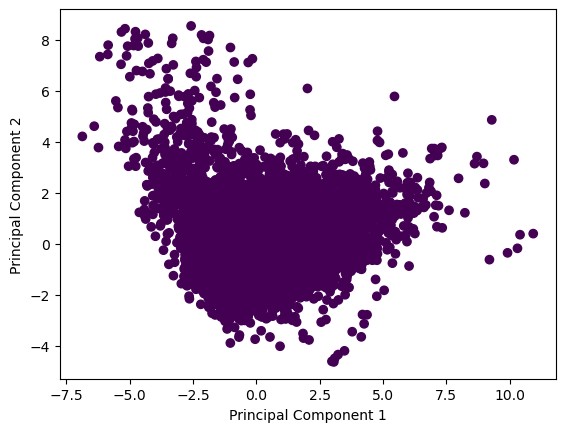

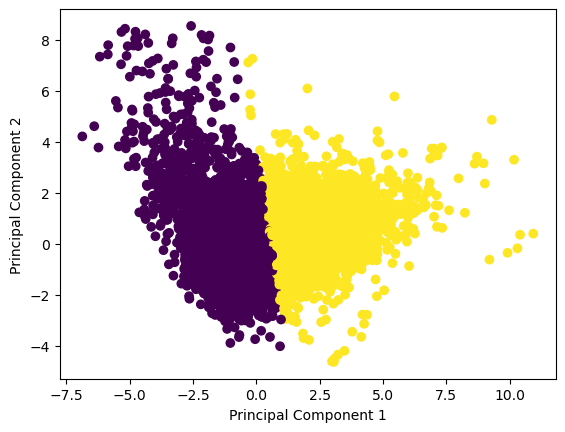

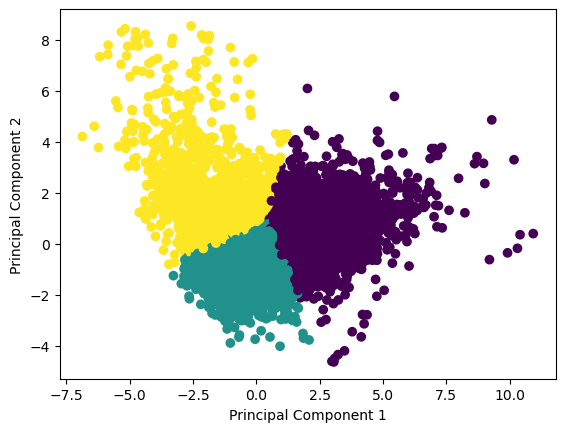

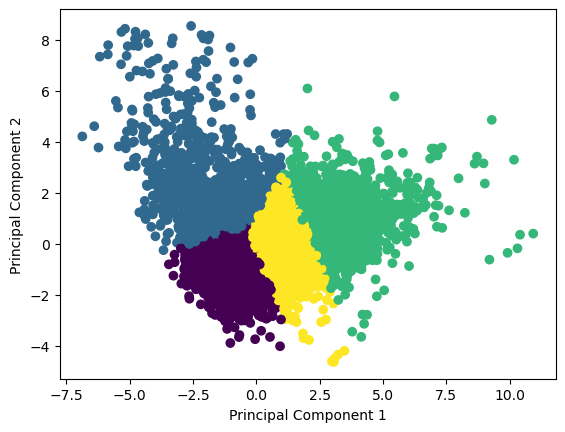

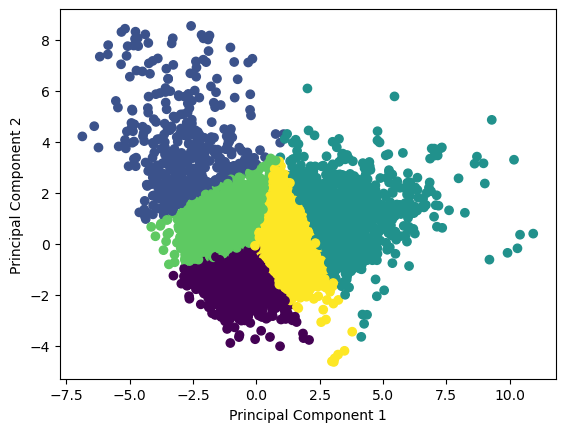

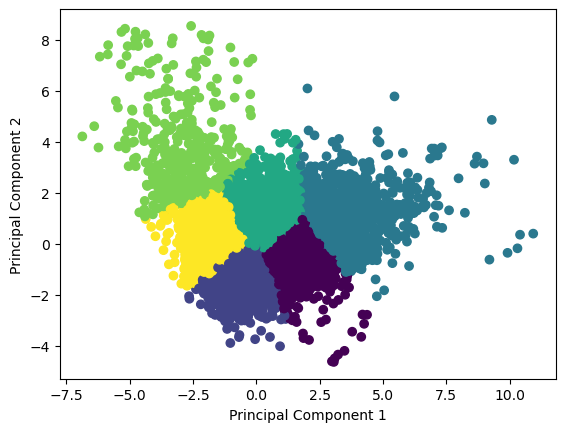

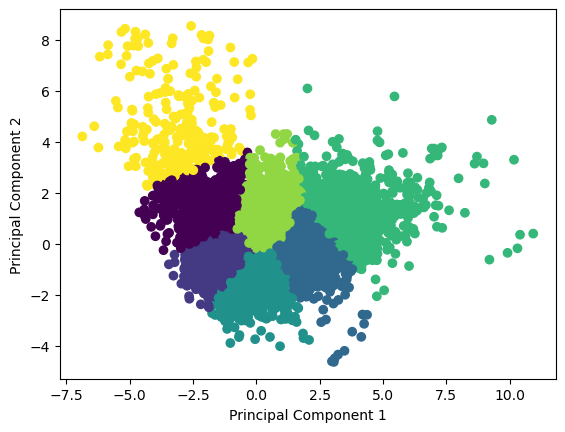

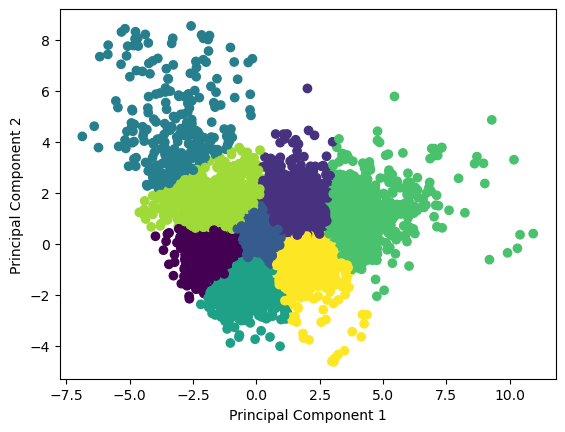

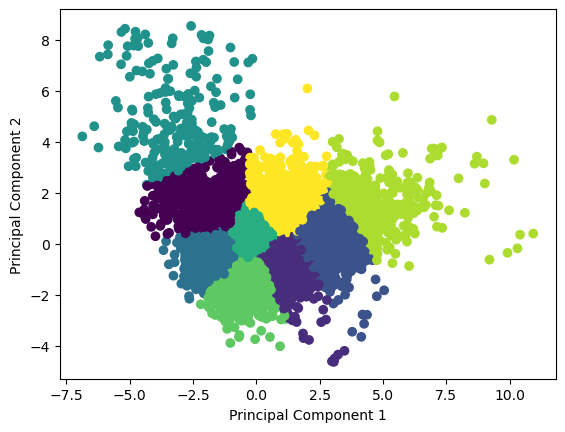

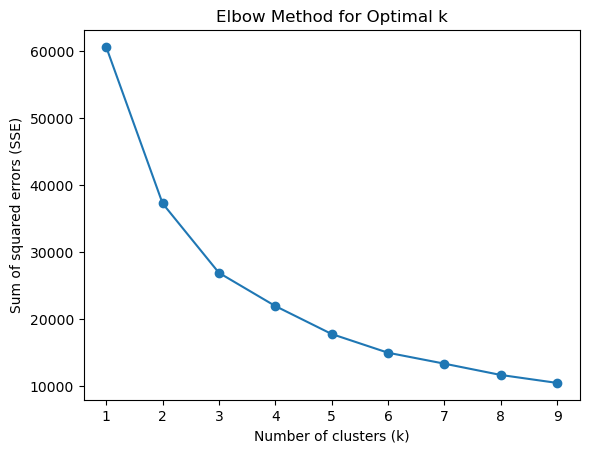

In [21]:
data_ct = metrics_standardized_ct

# Create an instance of the PCA class and specify the number of components you want to keep
pca = PCA(n_components=2)

# Fit the data to the PCA model
pca.fit(data_ct)
#print(pca.explained_variance_ratio_)

# Transform the data to the first two principal components
data_ct_pca = pca.transform(data_ct)

# Now that the data has been transformed to 2D, you can apply K-means or DBSCAN on the transformed data


sse = []
# K-means example
for i in range(1,10):
    kmeans = KMeans(n_clusters=i, n_init='auto')
    kmeans.fit(data_ct_pca)
    labels = kmeans.labels_
    sse.append(kmeans.inertia_)


    # Create a scatter plot of the data, using the first two principal components as the x and y axis
    plt.scatter(data_ct_pca[:, 0], data_ct_pca[:, 1], c=labels)#, cmap='rainbow')

    # Add labels to the axes
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')

    # Display the plot
    plt.show()



# Plot SSE versus k
plt.plot(range(1, 10), sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.show()

We then go on to plot a boxplot and look out for playstyles according to the distributions.

array([<Axes: title={'center': 'avg_speed'}, xlabel='[labels]'>,
       <Axes: title={'center': 'convex_hull'}, xlabel='[labels]'>,
       <Axes: title={'center': 'gyration_radius'}, xlabel='[labels]'>,
       <Axes: title={'center': 'start_to_end_distance'}, xlabel='[labels]'>,
       <Axes: title={'center': 'straightness_index'}, xlabel='[labels]'>,
       <Axes: title={'center': 'turning_points'}, xlabel='[labels]'>],
      dtype=object)

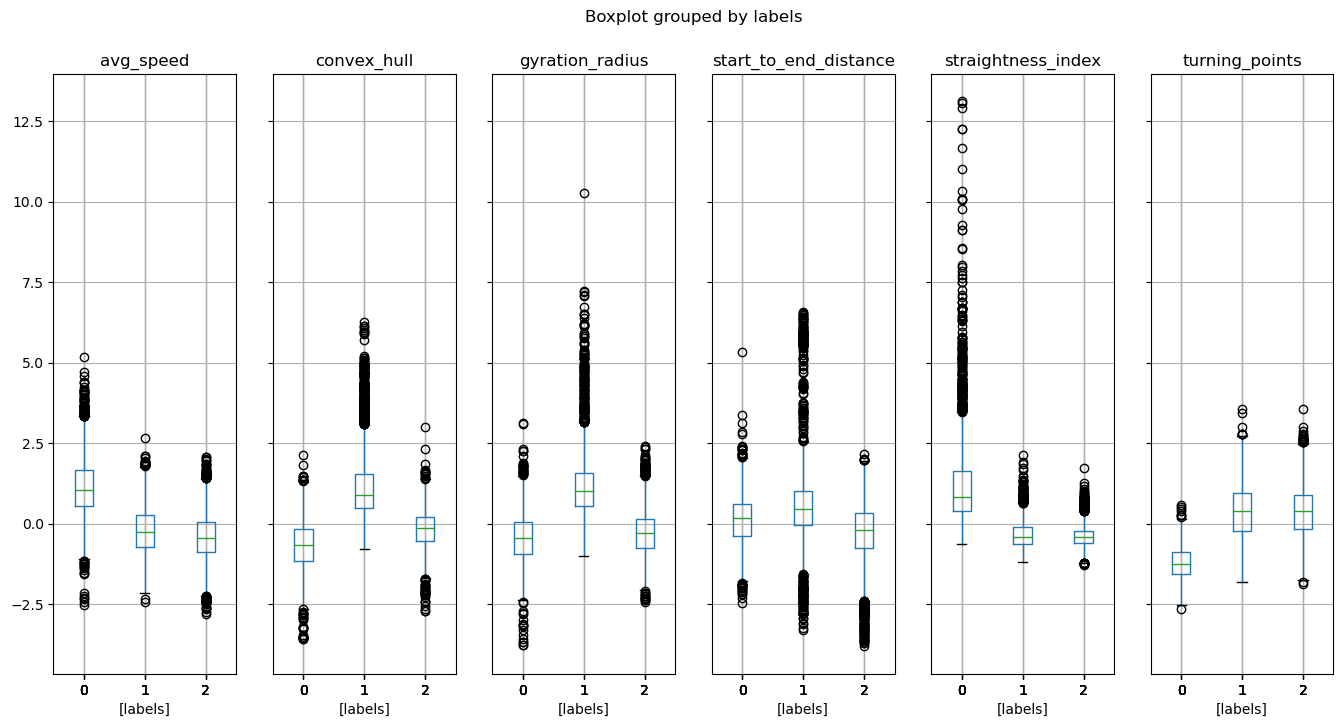

In [58]:
kmeans = KMeans(n_clusters=3, n_init='auto')
kmeans.fit(data_ct_pca)
labels_pca_ct = kmeans.labels_

metrics_stand_ct_nuke_df = pd.DataFrame(metrics_standardized_ct)

metrics_stand_ct_nuke_df.columns = ['start_to_end_distance', 'straightness_index',
                                    'turning_points', 'avg_speed', 'convex_hull', 'gyration_radius']
metrics_stand_ct_nuke_df['labels'] = labels_pca_ct

#grouped = metrics_stand_ct_nuke_df.groupby('labels')
#stats = grouped.agg(['mean', 'std', 'median'])
# Visualize differences using box plots
metrics_stand_ct_nuke_df.boxplot(by='labels', layout=(1, 6), figsize=(16, 8))


Here we do the same for the Terrorists:

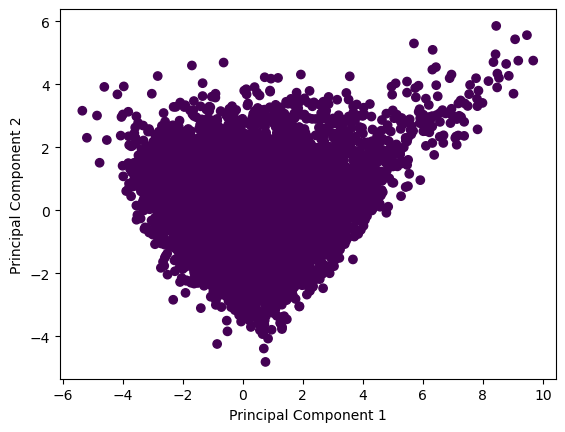

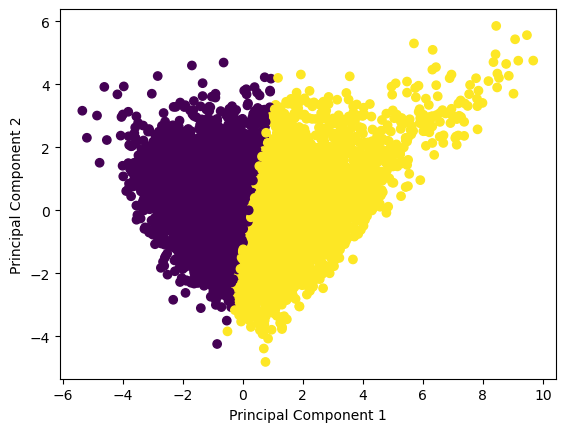

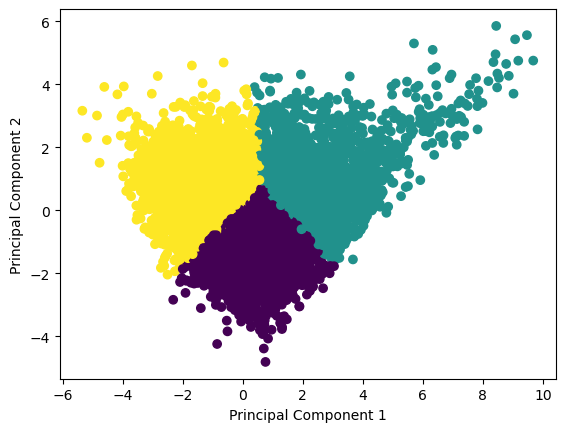

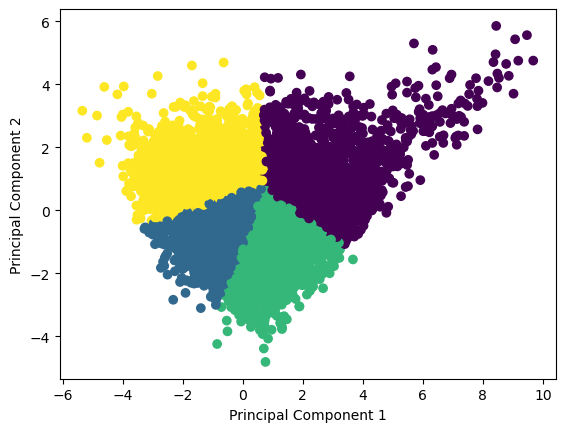

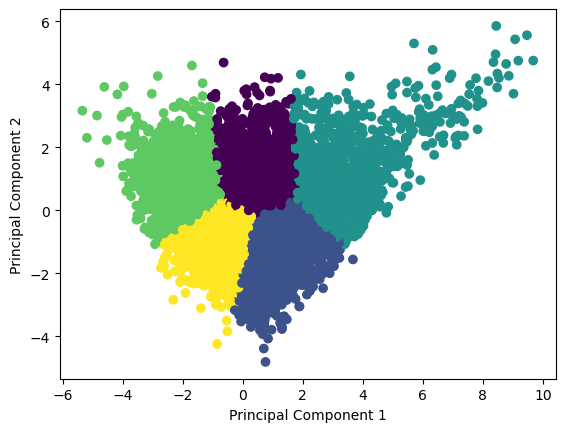

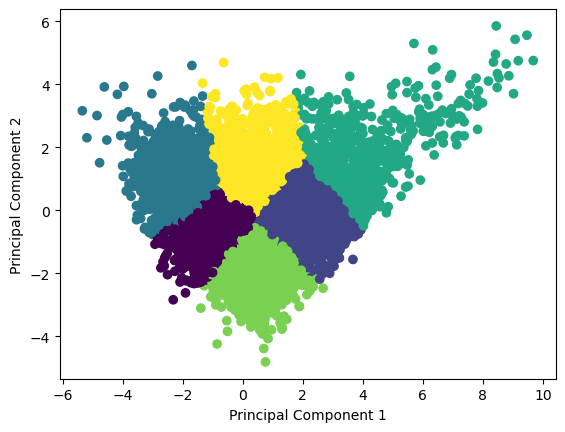

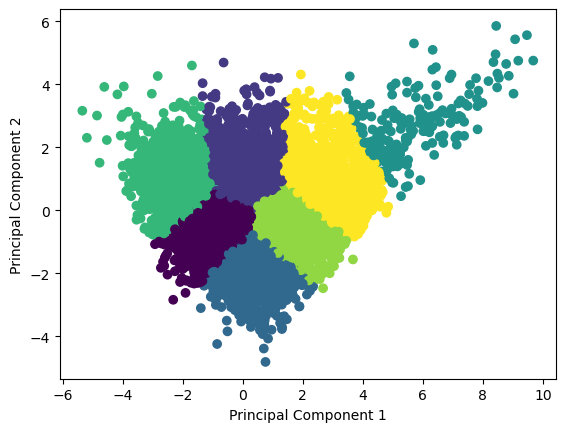

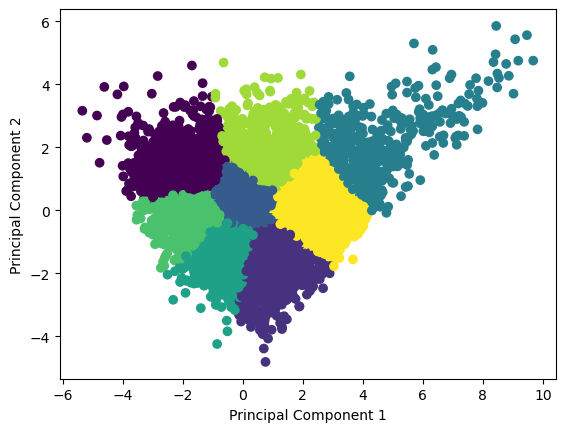

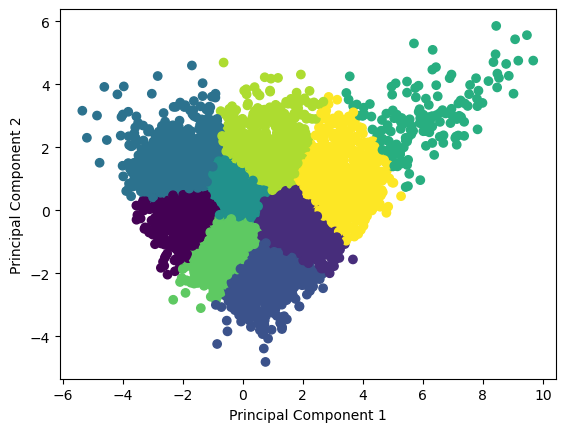

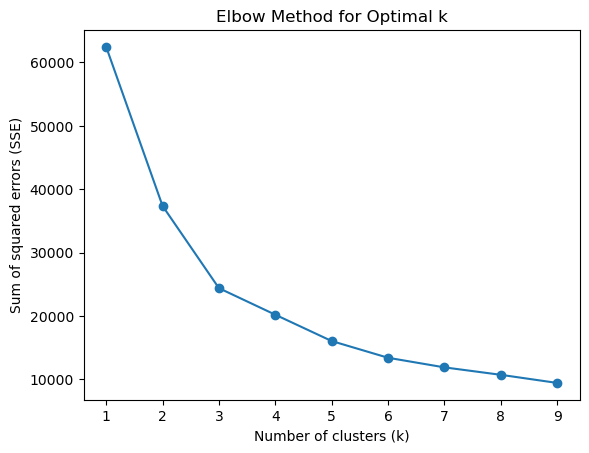

In [23]:
data_t = metrics_standardized_t

# Create an instance of the PCA class and specify the number of components you want to keep
pca = PCA(n_components=2)

# Fit the data to the PCA model
pca.fit(data_t)
#print(pca.explained_variance_ratio_)

# Transform the data to the first two principal components
data_pca_t = pca.transform(data_t)


sse = []
# K-means example
for i in range(1,10):
    kmeans = KMeans(n_clusters=i, n_init='auto')
    kmeans.fit(data_pca_t)
    labels = kmeans.labels_
    sse.append(kmeans.inertia_)


    # Create a scatter plot of the data, using the first two principal components as the x and y axis
    plt.scatter(data_pca_t[:, 0], data_pca_t[:, 1], c=labels)#, cmap='rainbow')

    # Add labels to the axes
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')

    # Display the plot
    plt.show()



# Plot SSE versus k
plt.plot(range(1, 10), sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.show()

array([<Axes: title={'center': 'avg_speed'}, xlabel='[labels]'>,
       <Axes: title={'center': 'convex_hull'}, xlabel='[labels]'>,
       <Axes: title={'center': 'gyration_radius'}, xlabel='[labels]'>,
       <Axes: title={'center': 'start_to_end_distance'}, xlabel='[labels]'>,
       <Axes: title={'center': 'straightness_index'}, xlabel='[labels]'>,
       <Axes: title={'center': 'turning_points'}, xlabel='[labels]'>],
      dtype=object)

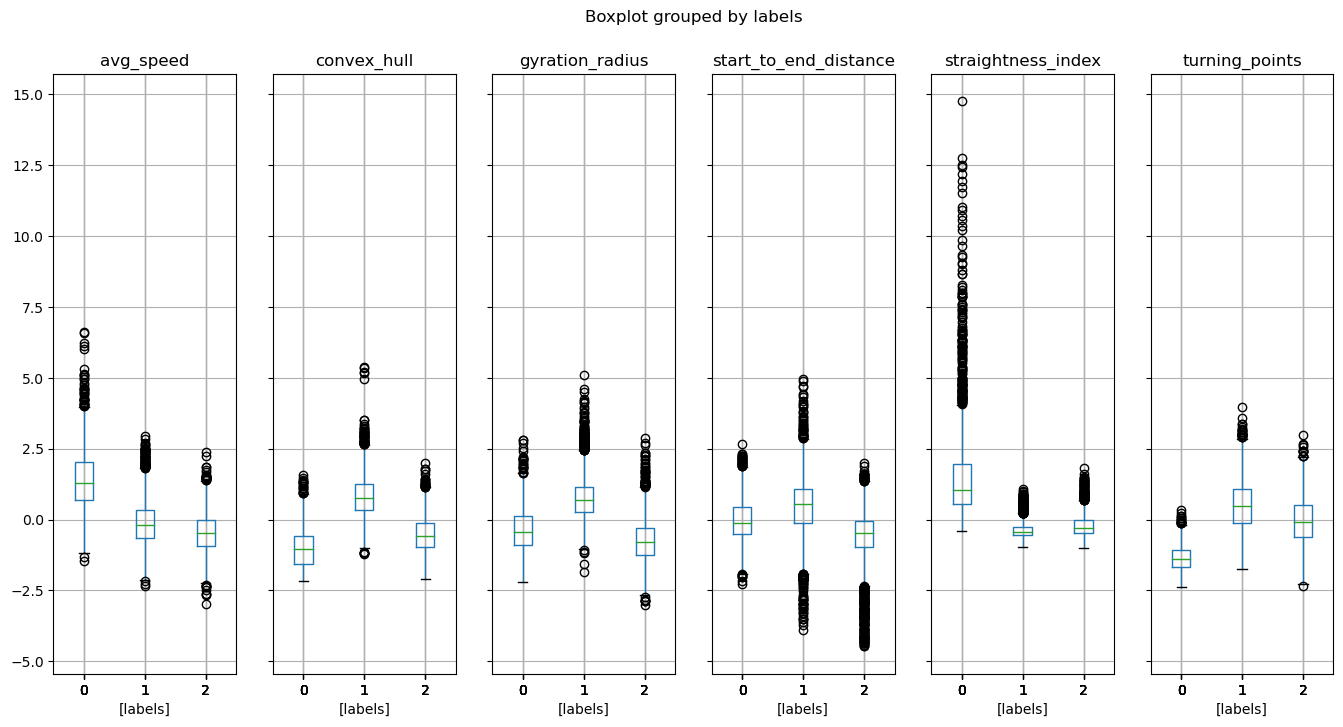

In [55]:
# Now that the data has been transformed to 2D, you can apply K-means or DBSCAN on the transformed data

kmeans = KMeans(n_clusters=3, n_init='auto')
kmeans.fit(data_pca_t)
labels_pca_t = kmeans.labels_

metrics_stand_t_nuke_df = pd.DataFrame(metrics_standardized_t)

metrics_stand_t_nuke_df.columns = ['start_to_end_distance', 'straightness_index',
                                    'turning_points', 'avg_speed', 'convex_hull', 'gyration_radius']
metrics_stand_t_nuke_df['labels'] = labels_pca_t

#grouped = metrics_stand_t_nuke_df.groupby('labels')
#stats = grouped.agg(['mean', 'std', 'median'])
# Visualize differences using box plots
metrics_stand_t_nuke_df.boxplot(by='labels', layout=(1, 6), figsize=(16, 8))


Here i have tried to apply some sequence algorithms like SeqDBScan, but unfortunately they didnt work out too well, so you **dont have to look into this further!**<br>

Edit: I have deleted them all since unnfortunately none of them seemed to work, this could be looked into further within the scope of another project!